# ハイパーパラメータ推定

## 0.設定

In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Random
using Plots.PlotMeasures; px
using NLsolve #非線形方程式解く用

In [3]:
# 現在(2021/12/02) inv()でstack overflow が発生するので暫定対処
# 環境：Julia V1.6.4
BLAS.set_num_threads(1)

In [4]:
#シード固定とプログラムで使う型を決める
rng = MersenneTwister(20220105)
FT = Float32

Float32

## 1.問題設定

予測する関数を設定

ガウス関数2つの重ね合わせ
$$
f(x) = a_1 \exp \left[ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right] + a_2 \exp \left[ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right]
$$

In [138]:
function exact(x, a₁=0.4, a₂=2.0, μ₁=0.3, μ₂=-0.6, σ₁=0.5, σ₂=0.2)
    ϕ = a₁ .* exp.(-(x .-μ₁).^2 ./(2*σ₁^2)) + a₂ .* exp.(-(x .- μ₂).^2 ./(2*σ₂^2))
end

exact (generic function with 7 methods)

In [60]:
# exact(x) = 1/(1+exp(-5x))

exact (generic function with 7 methods)

In [83]:
# exact(x) = 5*exp(-40(x+0.5)^2) + exp(-50(x-0.5)^2)

exact (generic function with 7 methods)

In [119]:
function make_data(FT=Float32; N=30, σₜ = 0.2, lₓ = 1)
    @eval N = $(N)
    @eval σₜ = $(σₜ)
    @eval lₓ = $(lₓ)
    # x_data: [-lₓ, lₓ)の一様分布
    # t_data: exact + 平均0, 標準偏差σₜの正規分布
    @eval x_data = Vector{$(FT)}((rand(rng, $(FT), N) .-0.5) .*(2*lₓ))
    @eval t_data = Vector{$(FT)}(exact.(x_data) .+ randn(rng, $(FT), N) .*σₜ)
    @eval x_dense = Vector{$(FT)}([i for i=-lₓ:2lₓ/50:lₓ])
    @eval t_dense = exact.(x_dense)
end

make_data (generic function with 2 methods)

## 2.エビデンス近似実装

ガウス過程

In [85]:
"""
theta3 = β⁻¹ : 共分散行列のノイズ
"""
function gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
    # repeat(x_data, 1, size(t_data)[1]) - repeat(t_data', size(x_data)[1])
    # .でキャスト、'で転置。Vector{N} - Matrix{1×M} = Matrix{N×M}
    x_diff = x1 .- x2' 
    @assert size(x_diff) == (size(x1)[1], size(x2)[1])
    kmat = θ₁ .* exp.(-(x_diff.^2) ./ θ₂) #アダマール積＆要素ごとのexp
    if x1==x2
        kmat += θ₃*I
    end
    return kmat
end

"""
 x: D次元空間
xtrain = Xₙ : x内のn個の測定点 Vector{n}
ytrain = tₙ : Xₙにおける測定値 Matrix{1×n}
xtest =  xₙ₊₁: 新しい測定点xₙ₊₁ Real or Vector{m}
K = Cₙ : 共分散行列 Matrix{n×n}
k_test = k : xₙとxₙ₊₁の相関? Vector{n} or Matrix{n×m}
k_diag = c : Real or 
"""
function gauss_process(Xₙ, tₙ, xₙ₊₁, func_kernel)
    # @show size(Xₙ)
    Cₙ⁻¹ = inv(func_kernel(Xₙ, Xₙ))
    k = func_kernel(Xₙ, xₙ₊₁)
    c = func_kernel(xₙ₊₁, xₙ₊₁)
    μ = k' * Cₙ⁻¹ * tₙ
    σ² = diag(c - k' * Cₙ⁻¹ * k).^0.5
    return μ, σ²
end

gauss_process

エビデンス近似

In [86]:
# ガウス過程エビデンス近似
"""
ガウスカーネル ノルム計算済みver
"""
function gauss_kernel_xdiff(x_diff_norm², θ₁, θ₂, θ₃)
    kmat = θ₁ .* exp.(-x_diff_norm² ./ θ₂) + θ₃*I
end

"""
dC/dθの計算
"""
function diff1(x_diff_norm², θ)
    exp.(-x_diff_norm²/(2*θ[2]))
end
function diff2(x_diff_norm², θ)
    θ[1]/(2*θ[2]^2) * x_diff_norm² .*exp.(-x_diff_norm²/(2*θ[2]))
end
function diff3(x_diff_norm², θ)
    1
end

function eqs(Xₙ, tₙ, Cₙ⁻¹, dif)
    -tr(Cₙ⁻¹*dif)/2 + tₙ' *Cₙ⁻¹ *dif *Cₙ⁻¹ *tₙ
end

function func!(F, x, param)
    θ₁, θ₂, θ₃ = x
    Xₙ, tₙ = param
    x_diff_norm² = (Xₙ .- Xₙ').^2
    Cₙ⁻¹ = inv(gauss_kernel_xdiff(x_diff_norm², θ₁, θ₂, θ₃))
    neqs(dif) = eqs(Xₙ, tₙ, Cₙ⁻¹, dif)
    F[1] = neqs(diff1(x_diff_norm², x))
    F[2] = neqs(diff2(x_diff_norm², x))
    F[3] = neqs(diff3(x_diff_norm², x))
end

func! (generic function with 1 method)

参考: [NLsolve](https://github.com/JuliaNLSolvers/NLsolve.jl)

In [127]:
function myplot(x_data, t_data, x_dense, μₘ, σₘ, label=""; dpi=20)
    param = Dict(:dpi=>dpi, :legend=>:bottomleft, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = scatter(x_data, t_data, label="data $(label)", shape=:+, markercolor=:deepskyblue; param...)
    plot!(exact, linecolor=:lime, label="model(unknown)")
    plot!(x_dense, μₘ, ribbon=σₘ, label="predict", fillalpha=0.1, color=:tomato) 
    return plt
end

myplot (generic function with 2 methods)

In [139]:
make_data(FT, N=20);

In [140]:
func_paramed!(F, x) = func!(F, x, (x_data, t_data))
sol = nlsolve(func_paramed!, [1 0.01 0.1])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0 0.01 0.1]
 * Zero: [1.754918459974882 0.21825586635798072 0.1508923247000525]
 * Inf-norm of residuals: 0.000000
 * Iterations: 10
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 11
 * Jacobian Calls (df/dx): 11

In [141]:
θevi = sol.zero
# 根が正確でないと、sol.f_convergedがfalseとなる
@assert sol.f_converged

In [142]:
θevi

1×3 Matrix{Float64}:
 1.75492  0.218256  0.150892

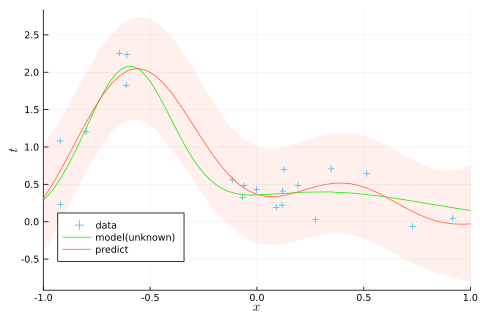

In [143]:
θ₁, θ₂, θ₃ = θevi
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
σₘ = σₘ² .^0.5
myplot(x_data, t_data, x_dense, μₘ, σₘ)

## 3．CV

In [187]:
# TODO 処理見直す
function findindex(num, x_mat, x_dense, μₘ)
    e = 5e-3
    mm = zeros(num)
    for (i, x) in enumerate(x_mat)
        f = x-e .<= x_dense .< x+e
#         @show μₘ[f]
        if μₘ[f]!=[]
            mm[i] = μₘ[f][1]
        else
            mm[i] = 0
        end
    end
    return mm
end

findindex (generic function with 1 method)

In [189]:
function myplots(plts; figsize=(1000, 1000), dpi=20)
    plot(plts..., layout=(size(plts)[1], 1), size=figsize, dpi=dpi)
end

myplots (generic function with 1 method)

In [160]:
make_data(FT, N=50);

5分割にする。
そもそもソートされていないので、そのまま５等分にする

In [161]:
K = 5
data_num = Int(ceil(N/K))
indexes = [(i-1)*data_num+1:i*data_num for i=1:K]

5-element Vector{UnitRange{Int64}}:
 1:10
 11:20
 21:30
 31:40
 41:50

$\theta_1, \theta_2, \theta_3$それぞれでCVを回す。

In [196]:
# θss = [0:0.1:5, 0:0.1:5, 0.001:0.0001:0.01]
θss = [0:0.1:5, 0.001:0.01:1, 0.01:0.1:1.0]

plts = []

for (k, θs) in enumerate(θss)
    train_error = zeros(length(θs))
    test_error = zeros(length(θs))
    # θ_0 = [1 0.01 0.1]
    θ_0 = [1.75492  0.218256  0.150892]
    for (j, θ) in enumerate(θs)
        θ_0[k] = θ
        θ₁, θ₂, θ₃ = θ_0
        for (i, index) in enumerate(indexes[1:K])
            test_flag = fill(false, N)
            test_flag[index] .= true
            x_train = x_data[.!test_flag]
            x_test = x_data[test_flag]
            t_train = t_data[.!test_flag]
            t_test = t_data[test_flag]
            # scatter!(x_train, t_train)
            gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
            μₘ, σₘ² = gauss_process(x_train, t_train, x_dense, gauss_kernel_param_fixed)
            μₘ = Vector{FT}(μₘ) #TODO エラーが出たので応急処置
            mm = findindex(N - data_num, x_train, x_dense, μₘ)
            train_error[j] += norm(t_train-mm)/(N-data_num)
        
            mm = findindex(data_num, x_test, x_dense, μₘ)
            test_error[j] += norm(t_test-mm)/data_num
            
        end
        train_error[j] /= K
        test_error[j] /=K
    end
    
    push!(plts, plot(θs, train_error, label="train"))
    plot!(θs, test_error, label="test");
end

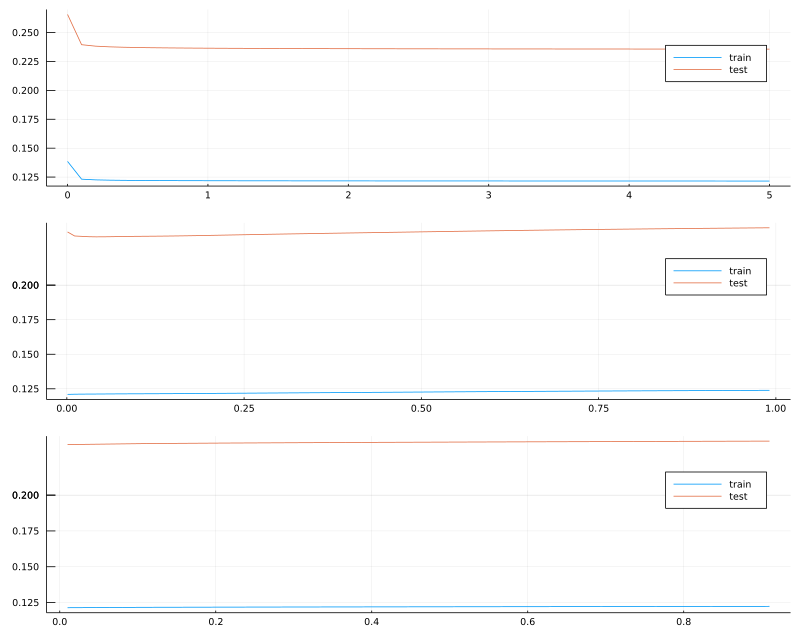

In [197]:
myplots(plts,figsize=(1000, 800))